# Description

### 0. dacon 제공 base line 코드에서 출발

* **macro f1 score 약 0.53**

- 기본 제공된 코드에 아래와 같은 변경 사항을 적용했습니다.
---

### 1. 데이터 전처리
    - 원하는 사이즈는 224x224이고, 학습 이미지를 원본 이미지의 4분의 1크기로 만들고 싶었기 때문에
    먼저 448x448로 만든 후에 224x224크기로 random crop 적용했습니다.
    - 문제 정의에 맞게 최적화하면 좋을 것 같은데 여러 시도를 하지는 못 했습니다.

### 2. mix up 사용
    - mix up을 사용하면 오버피팅을 줄이고 일반화 성능을 높일 수 있다고 해서 사용했습니다.

### 3. Optimizer SGD 사용
    - 다른 Optimizer보다 더 좋다기 보다는 시간이 부족해서 다양한 비교를 하지 못 했습니다.

### 4. learning scheduler : StepLR 사용
    - https://gaussian37.github.io/dl-pytorch-lr_scheduler/ 참고
    - 여러가지 사용하며 비교하고 싶었으나 시간이 부족했습니다.

### 5. 사전 학습 모델 efficientnet_b4, b7
    - efficient net의 각 모델은 최적 해상도가 있는 것으로 알고 있습니다만
    efficient net의 더 무거운 모델들이 b0보다는 성능이 좋았습니다.
    
* **1~5 조합시 : macro f1 score 최대 약 0.76**
    
---

### 6. soft  voting 적용

    - 1~5를 조합하여 만들어낸 몇 가지 모델들을 사용해 soft voting 기법을 적용해본 결과 약 0.02점의 향상이 있어서 아슬아슬하게 순위권에 들었습니다.
    - 이 기법은 이론만 보고 처음 구현해보았는데 실질적인 점수 향상이 있어서 이번 대회에서 가장 많이 배워간 부분입니다.
    
* **최종 macro f1 score score 약 0.78**

---

### 특이사항

    - 대회에서 제공된 base line 코드를 기반으로 작업을 했는데, 대회가 끝나고 확인해보니 Seed를 고정하기 위한 torch.backends.cudnn.benchmark 값이 True였습니다.
    - 관련 조사결과 모든 환경에서 완전히 동일한 재현을 하기 위해서는 이 값이 False여야 한다고 판단됩니다.
    - 저는 True인 상태에서 진행했기 때문에, 다른 사람의 환경에서도 저와 완전히 동일한 결과가 나오는 것을 보장할 수 없는 것 같습니다.
    - 같은 환경이어야 같은 결과가 나온다고 판단됩니다.(저도 2개의 환경에서 섞어 학습하며 대회를 진행했는데, 오차가 발생합니다.)
    - 앞으로 초반 개발때는 계산 속도를 위해서 True로 실험하더라도 제출할 모델을 학습할 때는 False로 변경하는 것이 재현을 위해서 좋을 것 같습니다.

## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import time
import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
device

device(type='cuda')

## Hyperparameter Setting

In [4]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':100,
    'LEARNING_RATE':0.005,
    'BATCH_SIZE':16,
    'SEED':41
}

## Fixed RandomSeed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [6]:
df = pd.read_csv('./train.csv')
df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [7]:
# Label Encoding
le = preprocessing.LabelEncoder()
df['artist'] = le.fit_transform(df['artist'].values)

## Train / Validation Split

In [8]:
train_df, val_df, _, _ = train_test_split(df, df['artist'].values, test_size=0.2, random_state=CFG['SEED'])

In [9]:
train_df = train_df.sort_values(by=['id'])
train_df.head()

,id,img_path,artist
0,0,./train/0000.jpg,9
2,2,./train/0002.jpg,7
3,3,./train/0003.jpg,10
5,5,./train/0005.jpg,38
6,6,./train/0006.jpg,43


In [10]:
val_df = val_df.sort_values(by=['id'])
val_df.head()

,id,img_path,artist
1,1,./train/0001.jpg,48
4,4,./train/0004.jpg,24
17,17,./train/0017.jpg,10
21,21,./train/0021.jpg,29
29,29,./train/0029.jpg,28


## Data Load

In [11]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].values
    return df['img_path'].values, df['artist'].values

In [12]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

## CustomDataset

In [13]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.labels is not None:
            label = self.labels[index]
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.img_paths)

In [14]:
# 원본 이미지의 1/4크기로 테스트가 들어올 것이기 때문에,
# 학습 이미지도 1/4크기로 잘라서 학습
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
                            A.RandomCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                            A.ShiftScaleRotate(p=0.5),
                            A.OneOf([
                                A.CLAHE(clip_limit=2),
                                A.RandomBrightnessContrast(),
                            ], p=0.3),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
                            A.RandomCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [15]:
train_dataset = CustomDataset(train_img_paths, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

val_dataset = CustomDataset(val_img_paths, val_labels, val_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0, pin_memory=True, drop_last=True)

## Model Define

In [16]:
class efficientnet_b4(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(efficientnet_b4, self).__init__()
        self.backbone = models.efficientnet_b4(pretrained=True, fine_tune=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

class efficientnet_b7(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(efficientnet_b7, self).__init__()
        self.backbone = models.efficientnet_b7(pretrained=True, fine_tune=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

## Train with mixup

In [17]:
mixup_alpha = 1.0

def mixup_data(x, y):
    lam = np.random.beta(mixup_alpha, mixup_alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_mixup(model, optimizer, train_loader, test_loader, scheduler, device):
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    lrs = []
    start = time.time()
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        epoch_start = time.time()
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.long().to(device)
            img, label_a, label_b, lam = mixup_data(img, label) # mix up
            optimizer.zero_grad()

            model_pred = model(img)
            loss = mixup_criterion(criterion, model_pred, label_a, label_b, lam)

            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        tr_loss = np.mean(train_loss)
            
        val_loss, val_score = validation(model, criterion, test_loader, device)
        
        lrs.append(optimizer.param_groups[0]["lr"])
        epoch_end = time.time()
        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
        print("epoch finished : ", datetime.timedelta(seconds=int(epoch_end-epoch_start)))
        if scheduler is not None:
            scheduler.step()
            
        if best_score < val_score:
            best_model = model
            best_score = val_score
    end = time.time()
    plt.plot(range(len(lrs)),lrs)
    print("train finished : ", datetime.timedelta(seconds=int(end-start)))
    return best_model

In [18]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation(model, criterion, test_loader, device):
    model.eval()
    
    model_preds = []
    true_labels = []
    
    val_loss = []
    
    with torch.no_grad():
        for img, label in tqdm(iter(test_loader)):
            img, label = img.float().to(device), label.long().to(device)
            
            model_pred = model(img)
            
            loss = criterion(model_pred, label)
            
            val_loss.append(loss.item())
            
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()
        
    val_f1 = competition_metric(true_labels, model_preds)
    return np.mean(val_loss), val_f1

## Run!!

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [1], Train Loss : [4.00220] Val Loss : [2.73346] Val F1 Score : [0.15944]
epoch finished :  0:02:09


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [2], Train Loss : [3.37690] Val Loss : [2.47938] Val F1 Score : [0.25057]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [3], Train Loss : [3.11769] Val Loss : [2.15884] Val F1 Score : [0.34383]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [4], Train Loss : [2.93506] Val Loss : [1.95155] Val F1 Score : [0.33623]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [5], Train Loss : [2.82561] Val Loss : [1.86017] Val F1 Score : [0.35750]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [6], Train Loss : [2.71261] Val Loss : [1.71458] Val F1 Score : [0.43696]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [7], Train Loss : [2.65325] Val Loss : [1.74941] Val F1 Score : [0.43824]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [8], Train Loss : [2.60398] Val Loss : [1.70712] Val F1 Score : [0.43881]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [9], Train Loss : [2.55013] Val Loss : [1.69642] Val F1 Score : [0.46510]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [10], Train Loss : [2.50564] Val Loss : [1.60326] Val F1 Score : [0.48711]
epoch finished :  0:02:01


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [11], Train Loss : [2.52016] Val Loss : [1.54024] Val F1 Score : [0.50313]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [12], Train Loss : [2.45658] Val Loss : [1.52222] Val F1 Score : [0.50787]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [13], Train Loss : [2.40591] Val Loss : [1.50581] Val F1 Score : [0.51330]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [14], Train Loss : [2.42338] Val Loss : [1.46709] Val F1 Score : [0.52391]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [15], Train Loss : [2.26992] Val Loss : [1.39264] Val F1 Score : [0.54366]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [16], Train Loss : [2.34589] Val Loss : [1.39548] Val F1 Score : [0.55447]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [17], Train Loss : [2.30660] Val Loss : [1.35134] Val F1 Score : [0.56369]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [18], Train Loss : [2.22426] Val Loss : [1.34161] Val F1 Score : [0.53541]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [19], Train Loss : [2.28697] Val Loss : [1.31081] Val F1 Score : [0.55852]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [20], Train Loss : [2.26158] Val Loss : [1.38517] Val F1 Score : [0.58644]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [21], Train Loss : [2.19323] Val Loss : [1.28819] Val F1 Score : [0.58515]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [22], Train Loss : [2.20923] Val Loss : [1.28248] Val F1 Score : [0.59661]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [23], Train Loss : [2.15512] Val Loss : [1.25714] Val F1 Score : [0.58589]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [24], Train Loss : [2.13517] Val Loss : [1.21480] Val F1 Score : [0.61269]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [25], Train Loss : [2.14654] Val Loss : [1.20998] Val F1 Score : [0.62784]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [26], Train Loss : [2.12489] Val Loss : [1.24252] Val F1 Score : [0.60499]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [27], Train Loss : [2.10072] Val Loss : [1.19197] Val F1 Score : [0.60763]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [28], Train Loss : [2.10553] Val Loss : [1.20696] Val F1 Score : [0.60411]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [29], Train Loss : [2.11386] Val Loss : [1.21067] Val F1 Score : [0.61100]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [30], Train Loss : [2.08876] Val Loss : [1.16497] Val F1 Score : [0.61174]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [31], Train Loss : [2.05796] Val Loss : [1.21478] Val F1 Score : [0.61084]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [32], Train Loss : [2.06430] Val Loss : [1.17926] Val F1 Score : [0.61369]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [33], Train Loss : [2.05686] Val Loss : [1.14968] Val F1 Score : [0.62763]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [34], Train Loss : [2.13496] Val Loss : [1.10642] Val F1 Score : [0.66147]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [35], Train Loss : [2.06756] Val Loss : [1.09322] Val F1 Score : [0.64036]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [36], Train Loss : [1.95999] Val Loss : [1.09192] Val F1 Score : [0.66149]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [37], Train Loss : [2.05320] Val Loss : [1.14461] Val F1 Score : [0.63869]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [38], Train Loss : [2.00867] Val Loss : [1.10396] Val F1 Score : [0.66230]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [39], Train Loss : [2.02216] Val Loss : [1.09314] Val F1 Score : [0.64975]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [40], Train Loss : [1.94239] Val Loss : [1.09965] Val F1 Score : [0.64243]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [41], Train Loss : [1.97448] Val Loss : [1.08309] Val F1 Score : [0.64090]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [42], Train Loss : [1.98443] Val Loss : [1.06541] Val F1 Score : [0.63984]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [43], Train Loss : [1.98441] Val Loss : [1.07754] Val F1 Score : [0.66955]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [44], Train Loss : [1.92453] Val Loss : [1.07418] Val F1 Score : [0.68323]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [45], Train Loss : [1.95672] Val Loss : [1.04159] Val F1 Score : [0.68239]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [46], Train Loss : [1.95329] Val Loss : [1.06262] Val F1 Score : [0.66179]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [47], Train Loss : [1.96353] Val Loss : [1.04517] Val F1 Score : [0.63538]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [48], Train Loss : [1.95516] Val Loss : [1.06111] Val F1 Score : [0.65370]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [49], Train Loss : [1.90389] Val Loss : [1.00747] Val F1 Score : [0.67074]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [50], Train Loss : [1.98759] Val Loss : [0.98994] Val F1 Score : [0.70840]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [51], Train Loss : [1.91346] Val Loss : [1.07477] Val F1 Score : [0.63653]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [52], Train Loss : [1.95902] Val Loss : [1.04250] Val F1 Score : [0.67413]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [53], Train Loss : [1.91764] Val Loss : [1.05248] Val F1 Score : [0.65710]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [54], Train Loss : [1.88968] Val Loss : [1.00482] Val F1 Score : [0.68054]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [55], Train Loss : [1.83707] Val Loss : [0.98238] Val F1 Score : [0.68846]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [56], Train Loss : [1.87777] Val Loss : [1.03000] Val F1 Score : [0.66993]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [57], Train Loss : [1.90217] Val Loss : [0.97693] Val F1 Score : [0.68532]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [58], Train Loss : [1.92212] Val Loss : [0.99101] Val F1 Score : [0.67875]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [59], Train Loss : [1.82339] Val Loss : [1.00523] Val F1 Score : [0.68407]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [60], Train Loss : [1.89910] Val Loss : [0.96705] Val F1 Score : [0.70422]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [61], Train Loss : [1.87415] Val Loss : [0.96206] Val F1 Score : [0.70777]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [62], Train Loss : [1.86855] Val Loss : [0.96425] Val F1 Score : [0.68919]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [63], Train Loss : [1.84378] Val Loss : [0.94443] Val F1 Score : [0.68902]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [64], Train Loss : [1.85766] Val Loss : [0.97422] Val F1 Score : [0.68949]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [65], Train Loss : [1.72259] Val Loss : [0.93984] Val F1 Score : [0.70160]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [66], Train Loss : [1.81285] Val Loss : [0.94089] Val F1 Score : [0.69907]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [67], Train Loss : [1.74868] Val Loss : [0.95134] Val F1 Score : [0.66784]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [68], Train Loss : [1.83258] Val Loss : [0.95895] Val F1 Score : [0.69707]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [69], Train Loss : [1.74995] Val Loss : [0.92957] Val F1 Score : [0.69788]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [70], Train Loss : [1.84401] Val Loss : [0.97779] Val F1 Score : [0.69236]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [71], Train Loss : [1.79428] Val Loss : [0.93562] Val F1 Score : [0.69261]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [72], Train Loss : [1.85231] Val Loss : [0.95437] Val F1 Score : [0.66395]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [73], Train Loss : [1.81674] Val Loss : [0.95164] Val F1 Score : [0.67989]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [74], Train Loss : [1.78535] Val Loss : [0.99436] Val F1 Score : [0.68782]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [75], Train Loss : [1.75357] Val Loss : [0.95628] Val F1 Score : [0.69753]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [76], Train Loss : [1.79272] Val Loss : [0.89532] Val F1 Score : [0.70632]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [77], Train Loss : [1.75122] Val Loss : [0.88150] Val F1 Score : [0.70925]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [78], Train Loss : [1.81323] Val Loss : [0.96124] Val F1 Score : [0.68395]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [79], Train Loss : [1.80173] Val Loss : [0.92047] Val F1 Score : [0.71032]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [80], Train Loss : [1.75005] Val Loss : [0.96569] Val F1 Score : [0.70163]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [81], Train Loss : [1.76642] Val Loss : [0.89829] Val F1 Score : [0.71784]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [82], Train Loss : [1.79380] Val Loss : [0.89508] Val F1 Score : [0.71849]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [83], Train Loss : [1.76836] Val Loss : [0.90033] Val F1 Score : [0.70637]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [84], Train Loss : [1.79753] Val Loss : [0.96561] Val F1 Score : [0.70595]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [85], Train Loss : [1.75503] Val Loss : [0.96112] Val F1 Score : [0.69994]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [86], Train Loss : [1.73406] Val Loss : [0.95108] Val F1 Score : [0.68105]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [87], Train Loss : [1.75936] Val Loss : [0.91325] Val F1 Score : [0.72372]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [88], Train Loss : [1.73222] Val Loss : [0.94130] Val F1 Score : [0.71126]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [89], Train Loss : [1.72219] Val Loss : [0.91991] Val F1 Score : [0.69170]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [90], Train Loss : [1.72908] Val Loss : [0.87483] Val F1 Score : [0.71236]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [91], Train Loss : [1.76338] Val Loss : [0.89784] Val F1 Score : [0.71167]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [92], Train Loss : [1.73546] Val Loss : [0.89194] Val F1 Score : [0.70639]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [93], Train Loss : [1.64543] Val Loss : [0.88195] Val F1 Score : [0.73838]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [94], Train Loss : [1.69372] Val Loss : [0.87178] Val F1 Score : [0.72474]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [95], Train Loss : [1.71216] Val Loss : [0.87754] Val F1 Score : [0.72626]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [96], Train Loss : [1.74727] Val Loss : [0.90594] Val F1 Score : [0.72076]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [97], Train Loss : [1.76360] Val Loss : [0.89972] Val F1 Score : [0.72272]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [98], Train Loss : [1.67491] Val Loss : [0.90884] Val F1 Score : [0.71002]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [99], Train Loss : [1.68665] Val Loss : [0.83214] Val F1 Score : [0.71623]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [100], Train Loss : [1.66626] Val Loss : [0.83514] Val F1 Score : [0.73094]
epoch finished :  0:01:57
train finished :  3:16:41


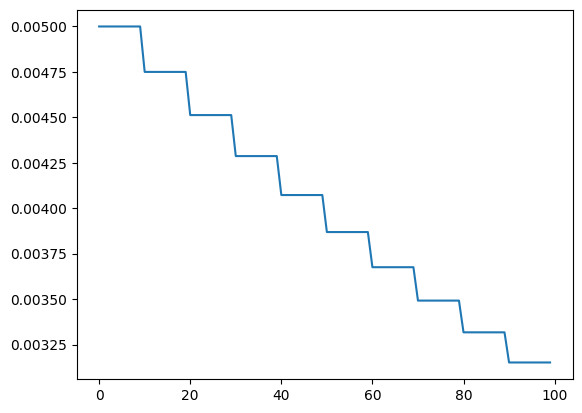

In [20]:
# model 1 (efficient net b4)
model = efficientnet_b4()
model.eval()
optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"], momentum = 0.9, weight_decay=0.0002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.95)

model1 = train_mixup(model, optimizer, train_loader, val_loader, scheduler, device)

In [21]:
torch.save(model1.state_dict(), "model1.pth")

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.69173] Val Loss : [0.87977] Val F1 Score : [0.70672]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [2], Train Loss : [1.73421] Val Loss : [0.86210] Val F1 Score : [0.71970]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [3], Train Loss : [1.66711] Val Loss : [0.86964] Val F1 Score : [0.72932]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [4], Train Loss : [1.76916] Val Loss : [0.88548] Val F1 Score : [0.72332]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [5], Train Loss : [1.68472] Val Loss : [0.84924] Val F1 Score : [0.72283]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [6], Train Loss : [1.73682] Val Loss : [0.88452] Val F1 Score : [0.73648]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [7], Train Loss : [1.66093] Val Loss : [0.90441] Val F1 Score : [0.71636]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [8], Train Loss : [1.74986] Val Loss : [0.87634] Val F1 Score : [0.72827]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [9], Train Loss : [1.69396] Val Loss : [0.83235] Val F1 Score : [0.74395]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [10], Train Loss : [1.70597] Val Loss : [0.83500] Val F1 Score : [0.73087]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [11], Train Loss : [1.65553] Val Loss : [0.86328] Val F1 Score : [0.72566]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [12], Train Loss : [1.71904] Val Loss : [0.86948] Val F1 Score : [0.73481]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [13], Train Loss : [1.61835] Val Loss : [0.86890] Val F1 Score : [0.71767]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [14], Train Loss : [1.72325] Val Loss : [0.83574] Val F1 Score : [0.73105]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [15], Train Loss : [1.68357] Val Loss : [0.80139] Val F1 Score : [0.71320]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [16], Train Loss : [1.64978] Val Loss : [0.82604] Val F1 Score : [0.73058]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [17], Train Loss : [1.66329] Val Loss : [0.83258] Val F1 Score : [0.73285]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [18], Train Loss : [1.65928] Val Loss : [0.84272] Val F1 Score : [0.71455]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [19], Train Loss : [1.69654] Val Loss : [0.89093] Val F1 Score : [0.70757]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [20], Train Loss : [1.62708] Val Loss : [0.85680] Val F1 Score : [0.74143]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [21], Train Loss : [1.64756] Val Loss : [0.80585] Val F1 Score : [0.75621]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [22], Train Loss : [1.60774] Val Loss : [0.82174] Val F1 Score : [0.73303]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [23], Train Loss : [1.57957] Val Loss : [0.79628] Val F1 Score : [0.75901]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [24], Train Loss : [1.65781] Val Loss : [0.82927] Val F1 Score : [0.71245]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [25], Train Loss : [1.64833] Val Loss : [0.85236] Val F1 Score : [0.70938]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [26], Train Loss : [1.58671] Val Loss : [0.83720] Val F1 Score : [0.72434]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [27], Train Loss : [1.59404] Val Loss : [0.81032] Val F1 Score : [0.74621]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [28], Train Loss : [1.63560] Val Loss : [0.81656] Val F1 Score : [0.74611]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [29], Train Loss : [1.65422] Val Loss : [0.83820] Val F1 Score : [0.72201]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [30], Train Loss : [1.63626] Val Loss : [0.78038] Val F1 Score : [0.76771]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [31], Train Loss : [1.61859] Val Loss : [0.80635] Val F1 Score : [0.73427]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [32], Train Loss : [1.60274] Val Loss : [0.83643] Val F1 Score : [0.72210]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [33], Train Loss : [1.72291] Val Loss : [0.86371] Val F1 Score : [0.71863]
epoch finished :  0:01:57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [34], Train Loss : [1.64037] Val Loss : [0.81944] Val F1 Score : [0.74119]
epoch finished :  0:02:02


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [35], Train Loss : [1.59036] Val Loss : [0.85205] Val F1 Score : [0.74335]
epoch finished :  0:01:59


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [36], Train Loss : [1.63156] Val Loss : [0.84820] Val F1 Score : [0.74274]
epoch finished :  0:01:59


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [37], Train Loss : [1.64847] Val Loss : [1.79774] Val F1 Score : [0.75379]
epoch finished :  0:01:59


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [38], Train Loss : [1.55915] Val Loss : [0.79273] Val F1 Score : [0.76292]
epoch finished :  0:01:59


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [39], Train Loss : [1.67840] Val Loss : [0.78803] Val F1 Score : [0.74644]
epoch finished :  0:01:59


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [40], Train Loss : [1.59185] Val Loss : [0.78697] Val F1 Score : [0.75739]
epoch finished :  0:02:01


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [41], Train Loss : [1.54715] Val Loss : [0.83033] Val F1 Score : [0.74999]
epoch finished :  0:02:00


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [42], Train Loss : [1.64796] Val Loss : [0.83031] Val F1 Score : [0.75375]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [43], Train Loss : [1.63625] Val Loss : [0.75202] Val F1 Score : [0.74241]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [44], Train Loss : [1.57891] Val Loss : [0.81083] Val F1 Score : [0.74269]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [45], Train Loss : [1.59199] Val Loss : [0.80901] Val F1 Score : [0.73913]
epoch finished :  0:01:58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [46], Train Loss : [1.56998] Val Loss : [0.80086] Val F1 Score : [0.73558]
epoch finished :  0:02:00


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [47], Train Loss : [1.62087] Val Loss : [0.82144] Val F1 Score : [0.74232]
epoch finished :  0:02:00


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [48], Train Loss : [1.61087] Val Loss : [0.82104] Val F1 Score : [0.72917]
epoch finished :  0:02:01


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [49], Train Loss : [1.59578] Val Loss : [0.83841] Val F1 Score : [0.73604]
epoch finished :  0:02:01


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch [50], Train Loss : [1.54896] Val Loss : [0.77062] Val F1 Score : [0.72984]
epoch finished :  0:02:03
train finished :  1:38:51


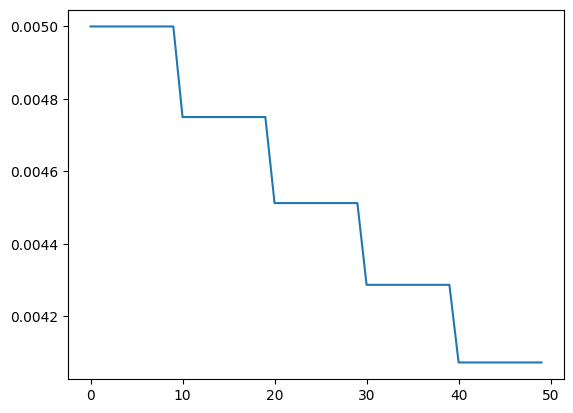

In [22]:
# model 2 (1 + 다시 epoch 50 학습)

CFG["EPOCHS"] = 50

model1.eval()
optimizer = torch.optim.SGD(params = model1.parameters(), lr = CFG["LEARNING_RATE"], momentum = 0.9, weight_decay=0.0002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.95)

model2 = train_mixup(model1, optimizer, train_loader, val_loader, scheduler, device)

In [23]:
torch.save(model2.state_dict(), "model2.pth")

  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [1], Train Loss : [3.27098] Val Loss : [2.20074] Val F1 Score : [0.26607]
epoch finished :  0:03:31


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [2], Train Loss : [2.79424] Val Loss : [1.91560] Val F1 Score : [0.35076]
epoch finished :  0:03:29


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [3], Train Loss : [2.62469] Val Loss : [1.68464] Val F1 Score : [0.43234]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [4], Train Loss : [2.52981] Val Loss : [1.48904] Val F1 Score : [0.48330]
epoch finished :  0:03:29


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [5], Train Loss : [2.42698] Val Loss : [1.41936] Val F1 Score : [0.51424]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [6], Train Loss : [2.42621] Val Loss : [1.39474] Val F1 Score : [0.52909]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [7], Train Loss : [2.34058] Val Loss : [1.29878] Val F1 Score : [0.56882]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [8], Train Loss : [2.25226] Val Loss : [1.25195] Val F1 Score : [0.58796]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [9], Train Loss : [2.22411] Val Loss : [1.23804] Val F1 Score : [0.57573]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [10], Train Loss : [2.19934] Val Loss : [1.20893] Val F1 Score : [0.57805]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [11], Train Loss : [2.12641] Val Loss : [1.10503] Val F1 Score : [0.62160]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [12], Train Loss : [2.07812] Val Loss : [1.18949] Val F1 Score : [0.60620]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [13], Train Loss : [2.10524] Val Loss : [1.09099] Val F1 Score : [0.61992]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [14], Train Loss : [2.05919] Val Loss : [1.07275] Val F1 Score : [0.64377]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [15], Train Loss : [2.04211] Val Loss : [1.10273] Val F1 Score : [0.62590]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [16], Train Loss : [2.03011] Val Loss : [1.09420] Val F1 Score : [0.62036]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [17], Train Loss : [2.05571] Val Loss : [1.06376] Val F1 Score : [0.64016]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [18], Train Loss : [1.95856] Val Loss : [1.08562] Val F1 Score : [0.64719]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [19], Train Loss : [1.99622] Val Loss : [1.06844] Val F1 Score : [0.65366]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [20], Train Loss : [1.95540] Val Loss : [1.03158] Val F1 Score : [0.63966]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [21], Train Loss : [1.90253] Val Loss : [0.99810] Val F1 Score : [0.68532]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [22], Train Loss : [1.89953] Val Loss : [0.98903] Val F1 Score : [0.67227]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [23], Train Loss : [1.91461] Val Loss : [0.97909] Val F1 Score : [0.69242]
epoch finished :  0:03:26


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [24], Train Loss : [1.91930] Val Loss : [0.99939] Val F1 Score : [0.67239]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [25], Train Loss : [1.87623] Val Loss : [0.98338] Val F1 Score : [0.65822]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [26], Train Loss : [1.87222] Val Loss : [0.95173] Val F1 Score : [0.68685]
epoch finished :  0:03:31


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [27], Train Loss : [1.86817] Val Loss : [0.98292] Val F1 Score : [0.68694]
epoch finished :  0:03:31


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [28], Train Loss : [1.81452] Val Loss : [0.94458] Val F1 Score : [0.68321]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [29], Train Loss : [1.88018] Val Loss : [1.06934] Val F1 Score : [0.67081]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [30], Train Loss : [1.83444] Val Loss : [1.02384] Val F1 Score : [0.66749]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [31], Train Loss : [1.85950] Val Loss : [0.99384] Val F1 Score : [0.69999]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [32], Train Loss : [1.79897] Val Loss : [0.99304] Val F1 Score : [0.68333]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [33], Train Loss : [1.73704] Val Loss : [1.00982] Val F1 Score : [0.67542]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [34], Train Loss : [1.75170] Val Loss : [0.89730] Val F1 Score : [0.71956]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [35], Train Loss : [1.79881] Val Loss : [0.94998] Val F1 Score : [0.71280]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [36], Train Loss : [1.78397] Val Loss : [1.05094] Val F1 Score : [0.67993]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [37], Train Loss : [1.77002] Val Loss : [0.91691] Val F1 Score : [0.71353]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [38], Train Loss : [1.75168] Val Loss : [0.92716] Val F1 Score : [0.70055]
epoch finished :  0:03:30


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [39], Train Loss : [1.77862] Val Loss : [1.03720] Val F1 Score : [0.67508]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [40], Train Loss : [1.75113] Val Loss : [0.95835] Val F1 Score : [0.71966]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [41], Train Loss : [1.75456] Val Loss : [0.96423] Val F1 Score : [0.70957]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [42], Train Loss : [1.76536] Val Loss : [0.96927] Val F1 Score : [0.68364]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [43], Train Loss : [1.72248] Val Loss : [0.98291] Val F1 Score : [0.70239]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [44], Train Loss : [1.74480] Val Loss : [0.99925] Val F1 Score : [0.69298]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [45], Train Loss : [1.69116] Val Loss : [0.97158] Val F1 Score : [0.70353]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [46], Train Loss : [1.73474] Val Loss : [0.99642] Val F1 Score : [0.70518]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [47], Train Loss : [1.61539] Val Loss : [1.00724] Val F1 Score : [0.69775]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [48], Train Loss : [1.71441] Val Loss : [0.98028] Val F1 Score : [0.71005]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [49], Train Loss : [1.69103] Val Loss : [0.99779] Val F1 Score : [0.69035]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [50], Train Loss : [1.62874] Val Loss : [0.94318] Val F1 Score : [0.72122]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [51], Train Loss : [1.66667] Val Loss : [0.97634] Val F1 Score : [0.72626]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [52], Train Loss : [1.68011] Val Loss : [0.96893] Val F1 Score : [0.69823]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [53], Train Loss : [1.65186] Val Loss : [0.94781] Val F1 Score : [0.69149]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [54], Train Loss : [1.63143] Val Loss : [0.94739] Val F1 Score : [0.70291]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [55], Train Loss : [1.66578] Val Loss : [1.01044] Val F1 Score : [0.70794]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [56], Train Loss : [1.63773] Val Loss : [1.04715] Val F1 Score : [0.67708]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [57], Train Loss : [1.67408] Val Loss : [1.02660] Val F1 Score : [0.68215]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [58], Train Loss : [1.60901] Val Loss : [0.96094] Val F1 Score : [0.71772]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [59], Train Loss : [1.63711] Val Loss : [0.96485] Val F1 Score : [0.69136]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [60], Train Loss : [1.64945] Val Loss : [0.99112] Val F1 Score : [0.70062]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [61], Train Loss : [1.60942] Val Loss : [0.86987] Val F1 Score : [0.75336]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [62], Train Loss : [1.61044] Val Loss : [1.02270] Val F1 Score : [0.67870]
epoch finished :  0:03:28


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [63], Train Loss : [1.56476] Val Loss : [0.99504] Val F1 Score : [0.70612]
epoch finished :  0:03:44


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [64], Train Loss : [1.64778] Val Loss : [0.97751] Val F1 Score : [0.72243]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [65], Train Loss : [1.61264] Val Loss : [1.04558] Val F1 Score : [0.69456]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [66], Train Loss : [1.62118] Val Loss : [0.93546] Val F1 Score : [0.72167]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [67], Train Loss : [1.67576] Val Loss : [1.03373] Val F1 Score : [0.69834]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [68], Train Loss : [1.60369] Val Loss : [0.97056] Val F1 Score : [0.71486]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [69], Train Loss : [1.61630] Val Loss : [1.00476] Val F1 Score : [0.68147]
epoch finished :  0:03:27


  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch [70], Train Loss : [1.60421] Val Loss : [0.97608] Val F1 Score : [0.69817]
epoch finished :  0:03:27
train finished :  4:02:53


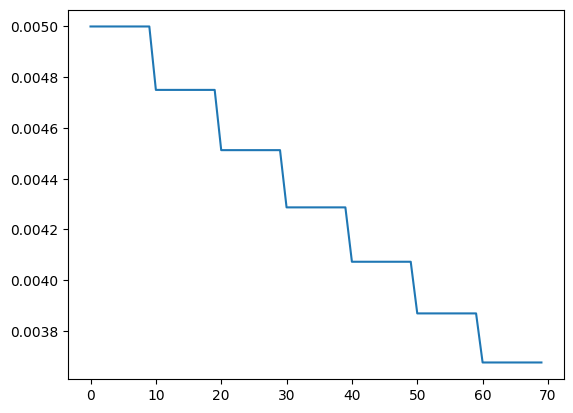

In [24]:
# model 3 (efficientnet b7)

CFG["EPOCHS"] = 70
CFG["BATCH_SIZE"] = 8

# 메모리 문제로 데이터 재구성
train_dataset = CustomDataset(train_img_paths, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

val_dataset = CustomDataset(val_img_paths, val_labels, val_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0, pin_memory=True, drop_last=True)

model = efficientnet_b7()
model.eval()
optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"], momentum = 0.9, weight_decay=0.0002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.95)

model3 = train_mixup(model, optimizer, train_loader, val_loader, scheduler, device)

In [25]:
torch.save(model3.state_dict(), "model3.pth")

## Inference

In [26]:
test_df = pd.read_csv('./test.csv')
test_df.head()

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


In [27]:
test_img_paths = get_data(test_df, infer=True)

In [28]:
test_dataset = CustomDataset(test_img_paths, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [37]:
vote_models = []

model1 = efficientnet_b4()
model1.load_state_dict(torch.load("model1.pth"))

model2 = efficientnet_b4()
model2.load_state_dict(torch.load("model2.pth"))

model3 = efficientnet_b7()
model3.load_state_dict(torch.load("model3.pth"))

vote_models.append(model1)
vote_models.append(model2)
vote_models.append(model3)

In [40]:
def inference_vote(models, test_loader, device):
    for model in models:
        model.to(device)
        model.eval()
    
    model_preds = []
    
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.float().to(device)
            vote_list = []
            percents = np.zeros((len(img), 50))
            for model in models:
                temp = []
                model_pred = model(img)
                percents += F.softmax(model_pred).detach().cpu().numpy()
                temp += model_pred.argmax(1).detach().cpu().numpy().tolist()
                vote_list.append(temp)
            model_preds +=  (percents / len(models)).argmax(1).tolist()
            
    print('Done.')
    return model_preds

# vote

In [41]:
preds = inference_vote(vote_models, test_loader, device)

  0%|          | 0/1584 [00:00<?, ?it/s]

Done.


In [42]:
preds = le.inverse_transform(preds) # LabelEncoder로 변환 된 Label을 다시 화가이름으로 변환

## Submit

In [43]:
submit = pd.read_csv('./sample_submission.csv')

In [44]:
submit['artist'] = preds
submit.head()

,id,artist
0,TEST_00000,Edgar Degas
1,TEST_00001,Amedeo Modigliani
2,TEST_00002,Titian
3,TEST_00003,Albrecht Du rer
4,TEST_00004,Vincent van Gogh


In [45]:
submit.to_csv('./submit_final_test.csv', index=False)